<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

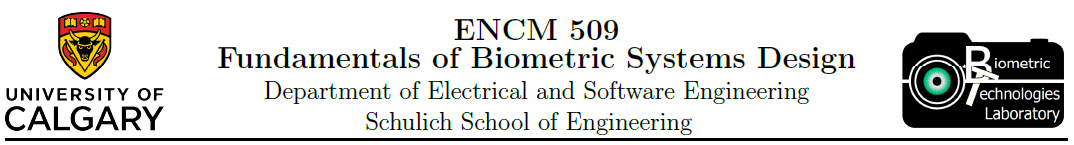

<center>
    <h1>Laboratory Experiment #4</h1>
    <h3>Fingerprint Biometrics - Part I: Preprocessing and Feature Extraction</h3>
    <h4>Youssef Abdel Maksoud, 30062891</h4>
</center>

# Introduction

The purpose of this exercise is to become familiar with image processing methods and feature extraction methods. Throughout the exercise, images will be enhaced using prepocessing methods such as histogram equalization, and denoising. Images are then taken through processing and the number of minutiae and singularities is compared using the original images, and the preprocessed images. Finally the number of singularities and minutiae is compared between three different processing pipelines: the first pipeline's block size and threshold are 16 and 0.4 respectively. The second pipeline's block size and threshold are 10 and 0.4 respectively. The final pipeline's block size and threshold are 16 and 0.5 respectively. 

In [2]:
import cv2 as cv
import numpy as np

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

# Exercise 1

In [21]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

In [22]:
img_right_good = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True));
img_right_bad = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/15.bmp', as_gray=True));
img_left_good = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/3.bmp', as_gray=True));
img_left_bad = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/18.bmp', as_gray=True));

input_img_rg = img_right_good.copy();
input_img_rb = img_right_bad.copy();
input_img_lg = img_left_good.copy();
input_img_lb = img_left_bad.copy();

print(np.min(img_right_good), np.max(img_right_good));
print(np.min(img_right_bad), np.max(img_right_bad));
print(np.min(img_left_good), np.max(img_left_good));
print(np.min(img_left_bad), np.max(img_left_bad));

0 255
0 255
0 255
0 255


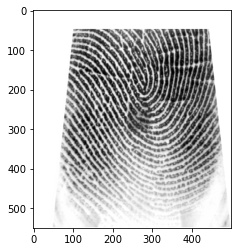

In [23]:
plt.imshow(img_right_good);

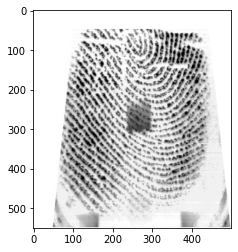

In [24]:
plt.imshow(img_right_bad);

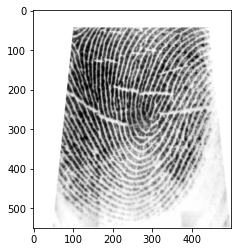

In [25]:
plt.imshow(img_left_good);

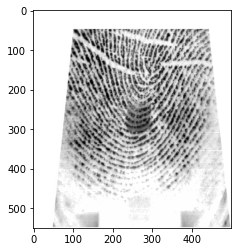

In [26]:
plt.imshow(img_left_bad);

## Right-Good

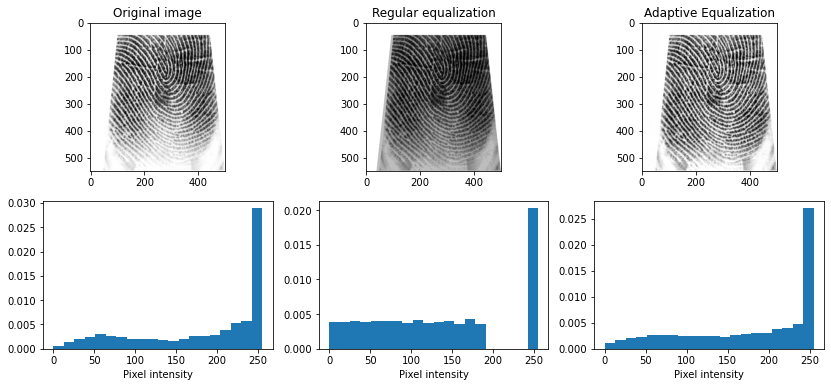

In [27]:
# equalize functions return a float adata 0-1
# to se as uint8 is necessary to convert
img_eq1 = img_as_ubyte(equalize_hist(img_right_good))
img_eq2 = img_as_ubyte(equalize_adapthist(img_right_good))

plt.figure(figsize=(14,6))
plt.subplot(2,3,1)
plt.imshow(img_right_good); plt.title('Original image')
plt.subplot(2,3,2)
plt.imshow(img_eq1); plt.title('Regular equalization')
plt.subplot(2,3,3)
plt.imshow(img_eq2); plt.title('Adaptive Equalization');
plt.subplot(2,3,4)
plt.hist(img_right_good.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(img_eq1.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(img_eq2.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');

### Original Image

In [31]:
preprocessed_image_right_good = fingerprint_processing(img_right_good);
preprocessed_image_right_good

Total of minutiae detected: 47
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 106, 107, 109],
        [109, 109, 109, ..., 108, 108, 109],
        [109, 109, 109, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.55721602,  0.55721602,  0.55721602, ...,  0.55721602,
          0.55721602,  0.55721602],
        [ 0.55721602,  0.55721602,  0.55721602, ...,  0.55721602,
          0.55721602,  0.55721602],
        [ 0.55721602,  0.55721602,  0.55721602, ...,  0.55721602,
          0.55721602,  0.55721602],
        ...,
        [ 0.55721602,  0.55721602,  0.55721602, ..., -0.51086093,
         -0.15483528,  0.55721602],
        [ 

### Regular Equalization

In [32]:
preprocessed_image_right_good2 = fingerprint_processing(img_eq1);
preprocessed_image_right_good2

Total of minutiae detected: 21
Total of singularities detected: 0


{'normalized_img': array([[113, 113, 113, ..., 113, 113, 113],
        [113, 113, 113, ..., 113, 113, 113],
        [113, 113, 113, ..., 113, 113, 113],
        ...,
        [113, 113, 113, ..., 101, 102, 113],
        [113, 113, 113, ..., 106, 106, 113],
        [113, 113, 113, ..., 106, 106, 106]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 1.01115959,  1.01115959,  1.01115959, ...,  1.01115959,
          1.01115959,  1.01115959],
        [ 1.01115959,  1.01115959,  1.01115959, ...,  1.01115959,
          1.01115959,  1.01115959],
        [ 1.01115959,  1.01115959,  1.01115959, ...,  1.01115959,
          1.01115959,  1.01115959],
        ...,
        [ 1.01115959,  1.01115959,  1.01115959, ..., -0.33808702,
         -0.22564981,  1.01115959],
        [ 

### Adaptive Equalization

In [33]:
preprocessed_image_right_good3 = fingerprint_processing(img_eq2);
preprocessed_image_right_good3

Total of minutiae detected: 52
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 103, 105, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.38238806,  0.38238806,  0.38238806, ...,  0.38238806,
          0.38238806,  0.38238806],
        [ 0.38238806,  0.38238806,  0.38238806, ...,  0.38238806,
          0.38238806,  0.38238806],
        [ 0.38238806,  0.38238806,  0.38238806, ...,  0.38238806,
          0.38238806,  0.38238806],
        ...,
        [ 0.38238806,  0.38238806,  0.38238806, ..., -1.79972451,
         -1.07235365,  0.38238806],
        [ 

### Conclusion

The number of minutiae detected in the **original image**, **regular equalized image**, and **adative equalized image** respectively is **47**, **21**, and **52**. The number of singularities detected respectively is **4**, **0**, and **4**. The original image is already of good quality. Using regular equalization creates an image with less contrast and as a result it is expected that there will be less minutiae, and singularities detected. The image with adaptive equalization applied provides more contract and as a result, it is expected to detect more minutiae. The number of detected singularites remains the same as the original image. 

## Right-Bad

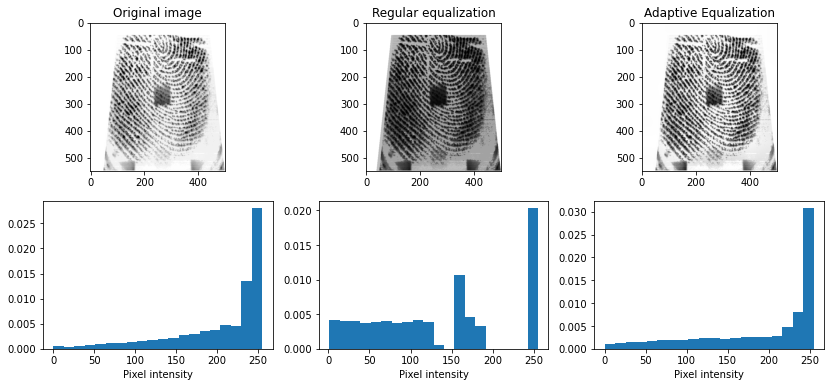

In [28]:
# equalize functions return a float adata 0-1
# to se as uint8 is necessary to convert
img_eq3 = img_as_ubyte(equalize_hist(img_right_bad))
img_eq4 = img_as_ubyte(equalize_adapthist(img_right_bad))

plt.figure(figsize=(14,6))
plt.subplot(2,3,1)
plt.imshow(img_right_bad); plt.title('Original image')
plt.subplot(2,3,2)
plt.imshow(img_eq3); plt.title('Regular equalization')
plt.subplot(2,3,3)
plt.imshow(img_eq4); plt.title('Adaptive Equalization');
plt.subplot(2,3,4)
plt.hist(img_right_bad.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(img_eq3.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(img_eq4.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');

### Original Image

In [34]:
preprocessed_image_right_bad1 = fingerprint_processing(img_right_bad);
preprocessed_image_right_bad1

Total of minutiae detected: 61
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ...,  93,  99, 108],
        [108, 108, 108, ..., 107, 107, 108],
        [108, 108, 108, ..., 107, 107, 107]], dtype=uint8),
 'segmented_img': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  93,  99, 108],
        [  0,   0,   0, ..., 107, 107, 108],
        [  0,   0,   0, ..., 107, 107, 107]], dtype=uint8),
 'normim': array([[ 0.49351834,  0.49351834,  0.49351834, ...,  0.49351834,
          0.49351834,  0.49351834],
        [ 0.49351834,  0.49351834,  0.49351834, ...,  0.49351834,
          0.49351834,  0.49351834],
        [ 0.49351834,  0.49351834,  0.49351834, ...,  0.49351834,
          0.49351834,  0.49351834],
        ...,
        [ 0.49351834,  0.49351834,  0.49

### Regular Equalization

In [35]:
preprocessed_image_right_bad2 = fingerprint_processing(img_eq3);
preprocessed_image_right_bad2

Total of minutiae detected: 49
Total of singularities detected: 4


{'normalized_img': array([[113, 113, 113, ..., 113, 113, 113],
        [113, 113, 113, ..., 113, 113, 113],
        [113, 113, 113, ..., 113, 113, 113],
        ...,
        [113, 113, 113, ...,  90,  93, 113],
        [113, 113, 113, ..., 105, 105, 113],
        [113, 113, 113, ..., 105, 105, 105]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.93525628,  0.93525628,  0.93525628, ...,  0.93525628,
          0.93525628,  0.93525628],
        [ 0.93525628,  0.93525628,  0.93525628, ...,  0.93525628,
          0.93525628,  0.93525628],
        [ 0.93525628,  0.93525628,  0.93525628, ...,  0.93525628,
          0.93525628,  0.93525628],
        ...,
        [ 0.93525628,  0.93525628,  0.93525628, ..., -1.41279286,
         -1.10652558,  0.93525628],
        [ 

### Adaptive Equalization

In [36]:
preprocessed_image_right_bad3 = fingerprint_processing(img_eq4);
preprocessed_image_right_bad3

Total of minutiae detected: 68
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ...,  89,  93, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  89,  93, 108],
        [  0,   0,   0, ..., 108, 108, 108],
        [  0,   0,   0, ..., 108, 108, 108]], dtype=uint8),
 'normim': array([[ 0.40166766,  0.40166766,  0.40166766, ...,  0.40166766,
          0.40166766,  0.40166766],
        [ 0.40166766,  0.40166766,  0.40166766, ...,  0.40166766,
          0.40166766,  0.40166766],
        [ 0.40166766,  0.40166766,  0.40166766, ...,  0.40166766,
          0.40166766,  0.40166766],
        ...,
        [ 0.40166766,  0.40166766,  0.40

### Conclusion

The number of minutiae detected in the **original image**, **regular equalized image**, and **adative equalized image** respectively is **61**, **49**, and **68**. The number of singularities detected respectively is **4**, **4**, and **4**. Using regular equalization creates an image with less contrast that appears darker, and as a result it is expected that there will be less minutiae detected. The image with adaptive equalization applied provides more contract and as a result, it is expected to detect more minutiae. The number of detected singularites remains the same as the original image. 

## Left-Good

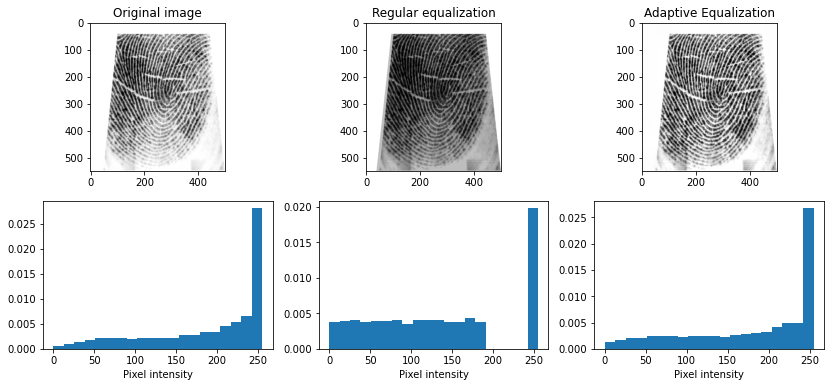

In [29]:
# equalize functions return a float adata 0-1
# to se as uint8 is necessary to convert
img_eq5 = img_as_ubyte(equalize_hist(img_left_good))
img_eq6 = img_as_ubyte(equalize_adapthist(img_left_good))

plt.figure(figsize=(14,6))
plt.subplot(2,3,1)
plt.imshow(img_left_good); plt.title('Original image')
plt.subplot(2,3,2)
plt.imshow(img_eq5); plt.title('Regular equalization')
plt.subplot(2,3,3)
plt.imshow(img_eq6); plt.title('Adaptive Equalization');
plt.subplot(2,3,4)
plt.hist(img_left_good.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(img_eq5.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(img_eq6.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');

### Original Image

In [37]:
preprocessed_image_left_good1 = fingerprint_processing(img_left_good);
preprocessed_image_left_good1

Total of minutiae detected: 84
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 105, 106, 109],
        [109, 109, 109, ..., 108, 108, 109],
        [109, 109, 109, ..., 108, 108, 109]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.59183999,  0.59183999,  0.59183999, ...,  0.59183999,
          0.59183999,  0.59183999],
        [ 0.59183999,  0.59183999,  0.59183999, ...,  0.59183999,
          0.59183999,  0.59183999],
        [ 0.59183999,  0.59183999,  0.59183999, ...,  0.59183999,
          0.59183999,  0.59183999],
        ...,
        [ 0.59183999,  0.59183999,  0.59183999, ..., -0.96400702,
         -0.57504527,  0.59183999],
        [ 

### Regular Equalization

In [38]:
preprocessed_image_left_good2 = fingerprint_processing(img_eq5);
preprocessed_image_left_good2

Total of minutiae detected: 5
Total of singularities detected: 0


{'normalized_img': array([[114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114],
        ...,
        [114, 114, 114, ..., 100, 102, 114],
        [114, 114, 114, ..., 106, 106, 114],
        [114, 114, 114, ..., 106, 106, 114]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 1.17528181,  1.17528181,  1.17528181, ...,  1.17528181,
          1.17528181,  1.17528181],
        [ 1.17528181,  1.17528181,  1.17528181, ...,  1.17528181,
          1.17528181,  1.17528181],
        [ 1.17528181,  1.17528181,  1.17528181, ...,  1.17528181,
          1.17528181,  1.17528181],
        ...,
        [ 1.17528181,  1.17528181,  1.17528181, ..., -0.22398728,
         -0.02409169,  1.17528181],
        [ 

### Adaptive Equalization

In [39]:
preprocessed_image_left_good3 = fingerprint_processing(img_eq6);
preprocessed_image_left_good3

Total of minutiae detected: 87
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 101, 104, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.45254649,  0.45254649,  0.45254649, ...,  0.45254649,
          0.45254649,  0.45254649],
        [ 0.45254649,  0.45254649,  0.45254649, ...,  0.45254649,
          0.45254649,  0.45254649],
        [ 0.45254649,  0.45254649,  0.45254649, ...,  0.45254649,
          0.45254649,  0.45254649],
        ...,
        [ 0.45254649,  0.45254649,  0.45254649, ..., -2.58870228,
         -1.44823399,  0.45254649],
        [ 

### Conclusion

The number of minutiae detected in the **original image**, **regular equalized image**, and **adative equalized image** respectively is **84**, **5**, and **87**. The number of singularities detected respectively is **4**, **0**, and **4**. The original image is already of good quality. Using regular equalization creates an image with less contrast and as a result it is expected that there will be far less minutiae and singularities detected. The image with adaptive equalization applied provides more contract and as a result, it is expected to detect more minutiae. The number of detected singularites remains the same as the original image. 

## Left-Bad

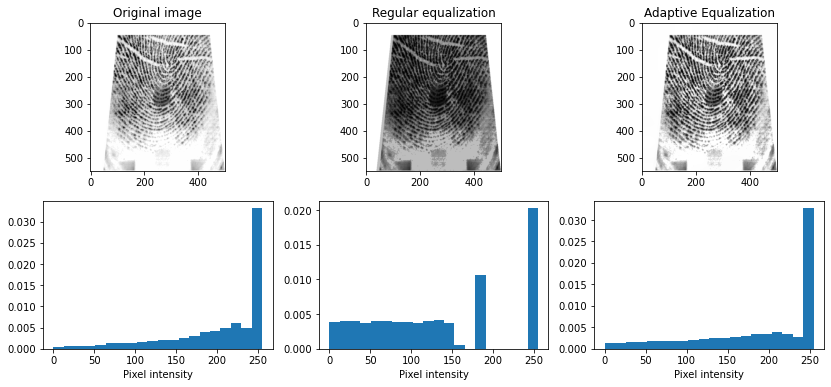

In [30]:
# equalize functions return a float adata 0-1
# to se as uint8 is necessary to convert
img_eq7 = img_as_ubyte(equalize_hist(img_left_bad))
img_eq8 = img_as_ubyte(equalize_adapthist(img_left_bad))

plt.figure(figsize=(14,6))
plt.subplot(2,3,1)
plt.imshow(img_left_bad); plt.title('Original image')
plt.subplot(2,3,2)
plt.imshow(img_eq7); plt.title('Regular equalization')
plt.subplot(2,3,3)
plt.imshow(img_eq8); plt.title('Adaptive Equalization');
plt.subplot(2,3,4)
plt.hist(img_left_bad.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(img_eq7.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(img_eq8.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');

### Original Image

In [40]:
preprocessed_image_left_bad1 = fingerprint_processing(img_left_bad);
preprocessed_image_left_bad1

Total of minutiae detected: 99
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ..., 100, 103, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ..., 100, 103, 108],
        [  0,   0,   0, ..., 108, 108, 108],
        [  0,   0,   0, ..., 108, 108, 108]], dtype=uint8),
 'normim': array([[ 0.4779275 ,  0.4779275 ,  0.4779275 , ...,  0.4779275 ,
          0.4779275 ,  0.4779275 ],
        [ 0.4779275 ,  0.4779275 ,  0.4779275 , ...,  0.4779275 ,
          0.4779275 ,  0.4779275 ],
        [ 0.4779275 ,  0.4779275 ,  0.4779275 , ...,  0.4779275 ,
          0.4779275 ,  0.4779275 ],
        ...,
        [ 0.4779275 ,  0.4779275 ,  0.47

### Regular Equalization

In [41]:
preprocessed_image_left_bad2 = fingerprint_processing(img_eq7);
preprocessed_image_left_bad2

Total of minutiae detected: 9
Total of singularities detected: 0


{'normalized_img': array([[113, 113, 113, ..., 113, 113, 113],
        [113, 113, 113, ..., 113, 113, 113],
        [113, 113, 113, ..., 113, 113, 113],
        ...,
        [113, 113, 113, ...,  95,  98, 113],
        [113, 113, 113, ..., 105, 105, 113],
        [113, 113, 113, ..., 105, 105, 105]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 1.18212758,  1.18212758,  1.18212758, ...,  1.18212758,
          1.18212758,  1.18212758],
        [ 1.18212758,  1.18212758,  1.18212758, ...,  1.18212758,
          1.18212758,  1.18212758],
        [ 1.18212758,  1.18212758,  1.18212758, ...,  1.18212758,
          1.18212758,  1.18212758],
        ...,
        [ 1.18212758,  1.18212758,  1.18212758, ..., -0.61056729,
         -0.31178482,  1.18212758],
        [ 

### Adaptive Equalization

In [42]:
preprocessed_image_left_bad3 = fingerprint_processing(img_eq8);
preprocessed_image_left_bad3

Total of minutiae detected: 92
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ...,  93,  98, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.4330278 ,  0.4330278 ,  0.4330278 , ...,  0.4330278 ,
          0.4330278 ,  0.4330278 ],
        [ 0.4330278 ,  0.4330278 ,  0.4330278 , ...,  0.4330278 ,
          0.4330278 ,  0.4330278 ],
        [ 0.4330278 ,  0.4330278 ,  0.4330278 , ...,  0.4330278 ,
          0.4330278 ,  0.4330278 ],
        ...,
        [ 0.4330278 ,  0.4330278 ,  0.4330278 , ..., -3.41697304,
         -2.13363943,  0.4330278 ],
        [ 

### Conclusion

The number of minutiae detected in the **original image**, **regular equalized image**, and **adative equalized image** respectively is **99**, **9**, and **92**. The number of singularities detected respectively is **4**, **0**, and **4**. Using regular equalization creates an image with less contrast and as a result it is expected that there will be less minutiae, and singularities detected. The image with adaptive equalization applied provides more contract but due to the image quality there are less minutiae detected. The number of detected singularites remains the same as the original image. 

# Exercise 2

### Median Filter For All Images

In [43]:
img_median_rg = median(img_right_good)
img_median_rb = median(img_right_bad)
img_median_lg = median(img_left_good)
img_median_lb = median(img_left_bad)

### Right-Good

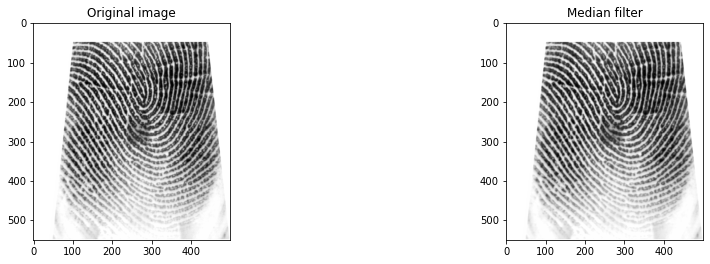

In [44]:
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(img_right_good); plt.title('Original image')
plt.subplot(1,3,3)
plt.imshow(img_median_rg); plt.title('Median filter');

### Original Image

In [48]:
preprocessed_rg = fingerprint_processing(img_right_good);
preprocessed_rg

Total of minutiae detected: 47
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 106, 107, 109],
        [109, 109, 109, ..., 108, 108, 109],
        [109, 109, 109, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.55721602,  0.55721602,  0.55721602, ...,  0.55721602,
          0.55721602,  0.55721602],
        [ 0.55721602,  0.55721602,  0.55721602, ...,  0.55721602,
          0.55721602,  0.55721602],
        [ 0.55721602,  0.55721602,  0.55721602, ...,  0.55721602,
          0.55721602,  0.55721602],
        ...,
        [ 0.55721602,  0.55721602,  0.55721602, ..., -0.51086093,
         -0.15483528,  0.55721602],
        [ 

### Filtered Image

In [49]:
preprocessed_rg_denoise = fingerprint_processing(img_median_rg);
preprocessed_rg_denoise

Total of minutiae detected: 32
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 107, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.52822718,  0.52822718,  0.52822718, ...,  0.52822718,
          0.52822718,  0.52822718],
        [ 0.52822718,  0.52822718,  0.52822718, ...,  0.52822718,
          0.52822718,  0.52822718],
        [ 0.52822718,  0.52822718,  0.52822718, ...,  0.52822718,
          0.52822718,  0.52822718],
        ...,
        [ 0.52822718,  0.52822718,  0.52822718, ..., -0.17909136,
          0.52822718,  0.52822718],
        [ 

### Conclusion

The number of minutiae detected in the **original image**, and **filtered image** respectively is **47**, and **32**. The number of singularities detected respectively is **4**, and **4**. Using a median filter does not visually alter the image to an extend that is readily noticeable. The filtered image detected the same number of singularities but detected less minutiae suggesting that the singe noise removed by the filter may have been misinterpreted as minutiae.

### Right-bad

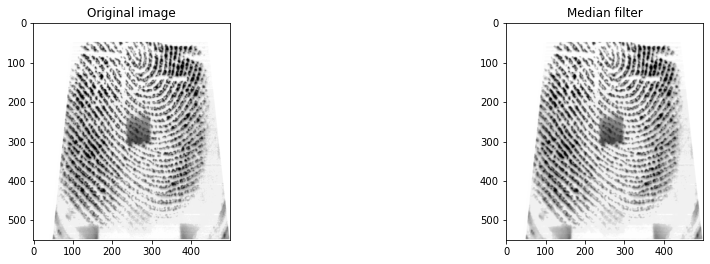

In [45]:
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(img_right_bad); plt.title('Original image')
plt.subplot(1,3,3)
plt.imshow(img_median_rb); plt.title('Median filter');

### Original Image

In [50]:
preprocessed_rb = fingerprint_processing(img_right_bad);
preprocessed_rb

Total of minutiae detected: 61
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ...,  93,  99, 108],
        [108, 108, 108, ..., 107, 107, 108],
        [108, 108, 108, ..., 107, 107, 107]], dtype=uint8),
 'segmented_img': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  93,  99, 108],
        [  0,   0,   0, ..., 107, 107, 108],
        [  0,   0,   0, ..., 107, 107, 107]], dtype=uint8),
 'normim': array([[ 0.49351834,  0.49351834,  0.49351834, ...,  0.49351834,
          0.49351834,  0.49351834],
        [ 0.49351834,  0.49351834,  0.49351834, ...,  0.49351834,
          0.49351834,  0.49351834],
        [ 0.49351834,  0.49351834,  0.49351834, ...,  0.49351834,
          0.49351834,  0.49351834],
        ...,
        [ 0.49351834,  0.49351834,  0.49

### Filtered Image

In [51]:
preprocessed_rb_denoise = fingerprint_processing(img_median_rb);
preprocessed_rb_denoise

Total of minutiae detected: 50
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ...,  98, 108, 108],
        [108, 108, 108, ..., 107, 108, 108],
        [108, 108, 108, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  98, 108, 108],
        [  0,   0,   0, ..., 107, 108, 108],
        [  0,   0,   0, ..., 108, 108, 108]], dtype=uint8),
 'normim': array([[ 0.47510175,  0.47510175,  0.47510175, ...,  0.47510175,
          0.47510175,  0.47510175],
        [ 0.47510175,  0.47510175,  0.47510175, ...,  0.47510175,
          0.47510175,  0.47510175],
        [ 0.47510175,  0.47510175,  0.47510175, ...,  0.47510175,
          0.47510175,  0.47510175],
        ...,
        [ 0.47510175,  0.47510175,  0.47

### Conclusion

The number of minutiae detected in the **original image**, and **filtered image** respectively is **61**, and **50**. The number of singularities detected respectively is **4**, and **4**. Using a median filter does not visually alter the image to an extend that is readily noticeable. The filtered image detected the same number of singularities but detected less minutiae suggesting that the singe noise removed by the filter may have been misinterpreted as minutiae.

### Left-Good

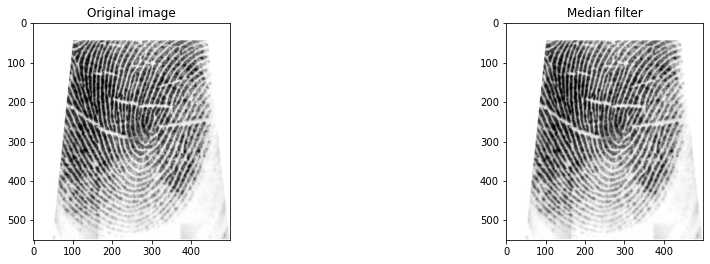

In [46]:
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(img_left_good); plt.title('Original image')
plt.subplot(1,3,3)
plt.imshow(img_median_lg); plt.title('Median filter');

### Original Image

In [52]:
preprocessed_lg = fingerprint_processing(img_left_good);
preprocessed_lg

Total of minutiae detected: 84
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 105, 106, 109],
        [109, 109, 109, ..., 108, 108, 109],
        [109, 109, 109, ..., 108, 108, 109]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.59183999,  0.59183999,  0.59183999, ...,  0.59183999,
          0.59183999,  0.59183999],
        [ 0.59183999,  0.59183999,  0.59183999, ...,  0.59183999,
          0.59183999,  0.59183999],
        [ 0.59183999,  0.59183999,  0.59183999, ...,  0.59183999,
          0.59183999,  0.59183999],
        ...,
        [ 0.59183999,  0.59183999,  0.59183999, ..., -0.96400702,
         -0.57504527,  0.59183999],
        [ 

### Filtered Image

In [53]:
preprocessed_lg_denoise = fingerprint_processing(img_median_lg);
preprocessed_lg_denoise

Total of minutiae detected: 72
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 106, 108, 109],
        [109, 109, 109, ..., 108, 108, 109],
        [109, 109, 109, ..., 108, 108, 109]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.60127577,  0.60127577,  0.60127577, ...,  0.60127577,
          0.60127577,  0.60127577],
        [ 0.60127577,  0.60127577,  0.60127577, ...,  0.60127577,
          0.60127577,  0.60127577],
        [ 0.60127577,  0.60127577,  0.60127577, ...,  0.60127577,
          0.60127577,  0.60127577],
        ...,
        [ 0.60127577,  0.60127577,  0.60127577, ..., -0.53195486,
          0.22353223,  0.60127577],
        [ 

### Conclusion

The number of minutiae detected in the **original image**, and **filtered image** respectively is **84**, and **72**. The number of singularities detected respectively is **4**, and **4**. Using a median filter does not visually alter the image to an extend that is readily noticeable. The filtered image detected the same number of singularities but detected less minutiae suggesting that the singe noise removed by the filter may have been misinterpreted as minutiae.

### Left-Bad

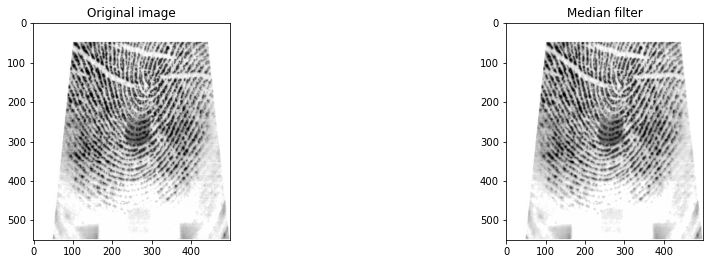

In [47]:
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(img_left_bad); plt.title('Original image')
plt.subplot(1,3,3)
plt.imshow(img_median_lb); plt.title('Median filter');

### Original Image

In [54]:
preprocessed_lb = fingerprint_processing(img_left_bad);
preprocessed_lb

Total of minutiae detected: 99
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ..., 100, 103, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ..., 100, 103, 108],
        [  0,   0,   0, ..., 108, 108, 108],
        [  0,   0,   0, ..., 108, 108, 108]], dtype=uint8),
 'normim': array([[ 0.4779275 ,  0.4779275 ,  0.4779275 , ...,  0.4779275 ,
          0.4779275 ,  0.4779275 ],
        [ 0.4779275 ,  0.4779275 ,  0.4779275 , ...,  0.4779275 ,
          0.4779275 ,  0.4779275 ],
        [ 0.4779275 ,  0.4779275 ,  0.4779275 , ...,  0.4779275 ,
          0.4779275 ,  0.4779275 ],
        ...,
        [ 0.4779275 ,  0.4779275 ,  0.47

### Filtered Image

In [55]:
preprocessed_lb_denoise = fingerprint_processing(img_median_lb);
preprocessed_lb_denoise

Total of minutiae detected: 98
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ..., 103, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ..., 103, 108, 108],
        [  0,   0,   0, ..., 108, 108, 108],
        [  0,   0,   0, ..., 108, 108, 108]], dtype=uint8),
 'normim': array([[ 0.48327333,  0.48327333,  0.48327333, ...,  0.48327333,
          0.48327333,  0.48327333],
        [ 0.48327333,  0.48327333,  0.48327333, ...,  0.48327333,
          0.48327333,  0.48327333],
        [ 0.48327333,  0.48327333,  0.48327333, ...,  0.48327333,
          0.48327333,  0.48327333],
        ...,
        [ 0.48327333,  0.48327333,  0.48

### Conclusion

The number of minutiae detected in the **original image**, and **filtered image** respectively is **99**, and **98**. The number of singularities detected respectively is **4**, and **4**. Using a median filter does not visually alter the image to an extend that is readily noticeable. The filtered image detected the same number of singularities but detected less minutiae. The number of minutiae was similar enough that it suggests that the effect of the filter was negligible possibly due to the poor image quality.

# Exercise 3

In [56]:
def fingerprint_processing_block_ten(img, block_size=10, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

In [57]:
def fingerprint_processing_thresh_point_five(img, block_size=16, threshold=0.5):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

### Right-Good

### Original Image

In [58]:
pprg1 = fingerprint_processing(img_right_good);
pprg1

Total of minutiae detected: 47
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 106, 107, 109],
        [109, 109, 109, ..., 108, 108, 109],
        [109, 109, 109, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.55721602,  0.55721602,  0.55721602, ...,  0.55721602,
          0.55721602,  0.55721602],
        [ 0.55721602,  0.55721602,  0.55721602, ...,  0.55721602,
          0.55721602,  0.55721602],
        [ 0.55721602,  0.55721602,  0.55721602, ...,  0.55721602,
          0.55721602,  0.55721602],
        ...,
        [ 0.55721602,  0.55721602,  0.55721602, ..., -0.51086093,
         -0.15483528,  0.55721602],
        [ 

### Block Size 10

In [59]:
pprg2 = fingerprint_processing_block_ten(img_right_good);
pprg2

Total of minutiae detected: 616
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 106, 107, 109],
        [109, 109, 109, ..., 108, 108, 109],
        [109, 109, 109, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.56678397,  0.56678397,  0.56678397, ...,  0.56678397,
          0.56678397,  0.56678397],
        [ 0.56678397,  0.56678397,  0.56678397, ...,  0.56678397,
          0.56678397,  0.56678397],
        [ 0.56678397,  0.56678397,  0.56678397, ...,  0.56678397,
          0.56678397,  0.56678397],
        ...,
        [ 0.56678397,  0.56678397,  0.56678397, ..., -0.32538068,
         -0.02799246,  0.56678397],
        [ 

### Threshold 0.5

In [60]:
pprg3 = fingerprint_processing_thresh_point_five(img_right_good);
pprg3

Total of minutiae detected: 40
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 106, 107, 109],
        [109, 109, 109, ..., 108, 108, 109],
        [109, 109, 109, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.5842665 ,  0.5842665 ,  0.5842665 , ...,  0.5842665 ,
          0.5842665 ,  0.5842665 ],
        [ 0.5842665 ,  0.5842665 ,  0.5842665 , ...,  0.5842665 ,
          0.5842665 ,  0.5842665 ],
        [ 0.5842665 ,  0.5842665 ,  0.5842665 , ...,  0.5842665 ,
          0.5842665 ,  0.5842665 ],
        ...,
        [ 0.5842665 ,  0.5842665 ,  0.5842665 , ..., -0.27884074,
          0.00886167,  0.5842665 ],
        [ 

### Conclusion

The number of minutiae detected in the **original image**, **block 10 image**, and **threshold 0.5 image** respectively is **47**, **616**, and **40**. The number of singularities detected respectively is **4**, **4**, and **4**. Decreasing the block size to 10 increases the number of detected minutiae, while increasing the threshold decreases the number of minutiae detected.

### Right-Bad

### Original Image

In [61]:
pprb1 = fingerprint_processing(img_right_bad);
pprb1

Total of minutiae detected: 61
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ...,  93,  99, 108],
        [108, 108, 108, ..., 107, 107, 108],
        [108, 108, 108, ..., 107, 107, 107]], dtype=uint8),
 'segmented_img': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  93,  99, 108],
        [  0,   0,   0, ..., 107, 107, 108],
        [  0,   0,   0, ..., 107, 107, 107]], dtype=uint8),
 'normim': array([[ 0.49351834,  0.49351834,  0.49351834, ...,  0.49351834,
          0.49351834,  0.49351834],
        [ 0.49351834,  0.49351834,  0.49351834, ...,  0.49351834,
          0.49351834,  0.49351834],
        [ 0.49351834,  0.49351834,  0.49351834, ...,  0.49351834,
          0.49351834,  0.49351834],
        ...,
        [ 0.49351834,  0.49351834,  0.49

### Block Size 10

In [62]:
pprb2 = fingerprint_processing_block_ten(img_right_bad);
pprb2

Total of minutiae detected: 580
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ...,  93,  99, 108],
        [108, 108, 108, ..., 107, 107, 108],
        [108, 108, 108, ..., 107, 107, 107]], dtype=uint8),
 'segmented_img': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  93,  99, 108],
        [  0,   0,   0, ..., 107, 107, 108],
        [  0,   0,   0, ..., 107, 107, 107]], dtype=uint8),
 'normim': array([[ 0.53202307,  0.53202307,  0.53202307, ...,  0.53202307,
          0.53202307,  0.53202307],
        [ 0.53202307,  0.53202307,  0.53202307, ...,  0.53202307,
          0.53202307,  0.53202307],
        [ 0.53202307,  0.53202307,  0.53202307, ...,  0.53202307,
          0.53202307,  0.53202307],
        ...,
        [ 0.53202307,  0.53202307,  0.53

### Threshold 0.5

In [63]:
pprb3 = fingerprint_processing_thresh_point_five(img_right_bad);
pprb3

Total of minutiae detected: 56
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ...,  93,  99, 108],
        [108, 108, 108, ..., 107, 107, 108],
        [108, 108, 108, ..., 107, 107, 107]], dtype=uint8),
 'segmented_img': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  93,  99, 108],
        [  0,   0,   0, ..., 107, 107, 108],
        [  0,   0,   0, ..., 107, 107, 107]], dtype=uint8),
 'normim': array([[ 0.52695096,  0.52695096,  0.52695096, ...,  0.52695096,
          0.52695096,  0.52695096],
        [ 0.52695096,  0.52695096,  0.52695096, ...,  0.52695096,
          0.52695096,  0.52695096],
        [ 0.52695096,  0.52695096,  0.52695096, ...,  0.52695096,
          0.52695096,  0.52695096],
        ...,
        [ 0.52695096,  0.52695096,  0.52

### Conclusion

The number of minutiae detected in the **original image**, **block 10 image**, and **threshold 0.5 image** respectively is **61**, **580**, and **56**. The number of singularities detected respectively is **4**, **4**, and **4**. Decreasing the block size to 10 increases the number of detected minutiae, while increasing the threshold decreases the number of minutiae detected.

### Left-Good

### Original Image

In [64]:
pplg1 = fingerprint_processing(img_left_good);
pplg1

Total of minutiae detected: 84
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 105, 106, 109],
        [109, 109, 109, ..., 108, 108, 109],
        [109, 109, 109, ..., 108, 108, 109]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.59183999,  0.59183999,  0.59183999, ...,  0.59183999,
          0.59183999,  0.59183999],
        [ 0.59183999,  0.59183999,  0.59183999, ...,  0.59183999,
          0.59183999,  0.59183999],
        [ 0.59183999,  0.59183999,  0.59183999, ...,  0.59183999,
          0.59183999,  0.59183999],
        ...,
        [ 0.59183999,  0.59183999,  0.59183999, ..., -0.96400702,
         -0.57504527,  0.59183999],
        [ 

### Block Size 10

In [65]:
pplg2 = fingerprint_processing_block_ten(img_left_good);
pplg2

Total of minutiae detected: 399
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 105, 106, 109],
        [109, 109, 109, ..., 108, 108, 109],
        [109, 109, 109, ..., 108, 108, 109]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.60588337,  0.60588337,  0.60588337, ...,  0.60588337,
          0.60588337,  0.60588337],
        [ 0.60588337,  0.60588337,  0.60588337, ...,  0.60588337,
          0.60588337,  0.60588337],
        [ 0.60588337,  0.60588337,  0.60588337, ...,  0.60588337,
          0.60588337,  0.60588337],
        ...,
        [ 0.60588337,  0.60588337,  0.60588337, ..., -0.61113486,
         -0.3068803 ,  0.60588337],
        [ 

### Threshold 0.5

In [66]:
pplg3 = fingerprint_processing_thresh_point_five(img_left_good);
pplg3

Total of minutiae detected: 56
Total of singularities detected: 4


{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        [109, 109, 109, ..., 109, 109, 109],
        ...,
        [109, 109, 109, ..., 105, 106, 109],
        [109, 109, 109, ..., 108, 108, 109],
        [109, 109, 109, ..., 108, 108, 109]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.62694345,  0.62694345,  0.62694345, ...,  0.62694345,
          0.62694345,  0.62694345],
        [ 0.62694345,  0.62694345,  0.62694345, ...,  0.62694345,
          0.62694345,  0.62694345],
        [ 0.62694345,  0.62694345,  0.62694345, ...,  0.62694345,
          0.62694345,  0.62694345],
        ...,
        [ 0.62694345,  0.62694345,  0.62694345, ..., -0.45470495,
         -0.18429285,  0.62694345],
        [ 

### Conclusion

The number of minutiae detected in the **original image**, **block 10 image**, and **threshold 0.5 image** respectively is **84**, **399**, and **56**. The number of singularities detected respectively is **4**, **4**, and **4**. Decreasing the block size to 10 increases the number of detected minutiae, while increasing the threshold decreases the number of minutiae detected.

### Left-Bad

### Original Image

In [67]:
pplb1 = fingerprint_processing(img_left_bad);
pplb1

Total of minutiae detected: 99
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ..., 100, 103, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ..., 100, 103, 108],
        [  0,   0,   0, ..., 108, 108, 108],
        [  0,   0,   0, ..., 108, 108, 108]], dtype=uint8),
 'normim': array([[ 0.4779275 ,  0.4779275 ,  0.4779275 , ...,  0.4779275 ,
          0.4779275 ,  0.4779275 ],
        [ 0.4779275 ,  0.4779275 ,  0.4779275 , ...,  0.4779275 ,
          0.4779275 ,  0.4779275 ],
        [ 0.4779275 ,  0.4779275 ,  0.4779275 , ...,  0.4779275 ,
          0.4779275 ,  0.4779275 ],
        ...,
        [ 0.4779275 ,  0.4779275 ,  0.47

### Block Size 10

In [68]:
pplb2 = fingerprint_processing_block_ten(img_left_bad);
pplb2

Total of minutiae detected: 469
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ..., 100, 103, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ..., 100, 103, 108],
        [  0,   0,   0, ..., 108, 108, 108],
        [  0,   0,   0, ..., 108, 108, 108]], dtype=uint8),
 'normim': array([[ 0.50888704,  0.50888704,  0.50888704, ...,  0.50888704,
          0.50888704,  0.50888704],
        [ 0.50888704,  0.50888704,  0.50888704, ...,  0.50888704,
          0.50888704,  0.50888704],
        [ 0.50888704,  0.50888704,  0.50888704, ...,  0.50888704,
          0.50888704,  0.50888704],
        ...,
        [ 0.50888704,  0.50888704,  0.50

### Threshold 0.5

In [69]:
pplb3 = fingerprint_processing_thresh_point_five(img_left_bad);
pplb3

Total of minutiae detected: 99
Total of singularities detected: 4


{'normalized_img': array([[108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108],
        ...,
        [108, 108, 108, ..., 100, 103, 108],
        [108, 108, 108, ..., 108, 108, 108],
        [108, 108, 108, ..., 108, 108, 108]], dtype=uint8),
 'segmented_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'normim': array([[ 0.50709764,  0.50709764,  0.50709764, ...,  0.50709764,
          0.50709764,  0.50709764],
        [ 0.50709764,  0.50709764,  0.50709764, ...,  0.50709764,
          0.50709764,  0.50709764],
        [ 0.50709764,  0.50709764,  0.50709764, ...,  0.50709764,
          0.50709764,  0.50709764],
        ...,
        [ 0.50709764,  0.50709764,  0.50709764, ..., -1.44179736,
         -0.71096174,  0.50709764],
        [ 

### Conclusion

The number of minutiae detected in the **original image**, **block 10 image**, and **threshold 0.5 image** respectively is **99**, **469**, and **99**. The number of singularities detected respectively is **4**, **4**, and **4**. Decreasing the block size to 10 increases the number of detected minutiae, while increasing the threshold did not effect the number of minutiae detected possibly due to the original image quality.

# Conclusion

It is evident that different methods of preprocessing yield slightly different results, but these trends vary slightly depending on the original image quality. Generally speaking, using adaptive equalization on an image and then processing it typically detects more minutiae. Using regular equalization created an image with less contrast which resulted in the detection of less minutiae and singularities. Decreasing the block size of the processing pipeline seems to drastically increase the number of minutiae detected, while increasing the threshold slightly seemed to slightly decrease the number of minutiae detected.